In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
# ==========================================
# PHASE 1: BUSINESS UNDERSTANDING & DATA LOADING
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Libraries Loaded Successfully")

# 1. LOAD DATASET UTAMA (children_malnutrition_ethiopia.csv)
try:
    df_real = pd.read_csv('children_malnutrition_ethiopia.csv', sep=',') 
    print(f"✅ Dataset children_malnutrition_ethiopia.csv Loaded: {df_real.shape[0]} rows")
    print(f"   Kolom tersedia: {df_real.columns.tolist()}")
except FileNotFoundError:
    print("FATAL ERROR: File 'children_malnutrition_ethiopia.csv' tidak ditemukan! Pastikan file sudah di-upload.")

def load_who_reference():
    print("\n--- MULAI MEMUAT STANDAR WHO ---")
    
    if not os.path.exists('who'):
        print("FATAL ERROR: Folder 'who/' tidak ditemukan!")
        return None

    files = {
        'bfa_boys_0_2': 'who/bfa_boys_0_2.csv', 'bfa_boys_2_5': 'who/bfa_boys_2_5.csv',
        'bfa_girls_0_2': 'who/bfa_girls_0_2.csv', 'bfa_girls_2_5': 'who/bfa_girls_2_5.csv',
        'hfa_boys_0_2': 'who/hfa_boys_0_2.csv', 'hfa_boys_2_5': 'who/hfa_boys_2_5.csv',
        'hfa_girls_0_2': 'who/hfa_girls_0_2.csv', 'hfa_girls_2_5': 'who/hfa_girls_2_5.csv',
        'wfa_boys': 'who/wfa_boys.csv', 'wfa_girls': 'who/wfa_girls.csv',
        'acfa_boys': 'who/acfa_boys.csv', 'acfa_girls': 'who/acfa_girls.csv'
    }
    
    data = {}
    is_error = False
    
    for key, path in files.items():
        if not os.path.exists(path):
            print(f"FILE HILANG: {path}")
            is_error = True
            continue
            
        try:
            df = pd.read_csv(path, sep=';', decimal=',')
            
            if len(df.columns) <= 1:
                df = pd.read_csv(path, sep=',', decimal='.')
            
            df.columns = df.columns.str.strip()
            
            if 'Month' not in df.columns:
                 print(f"⚠️ ISU FORMAT: File {key} tidak punya kolom 'Month'.")
                 print(f"   Kolom terbaca: {df.columns.tolist()}")
                 is_error = True
            else:
                data[key] = df
            
        except Exception as e:
            print(f"❌ ERROR BACA FILE {path}: {e}")
            is_error = True

    if is_error:
        print("\n⚠️ ADA FILE BERMASALAH. Cek pesan di atas.")
    
    def merge_segments(df1, df2):
        if df1 is None or df2 is None: return None
        return pd.concat([df1, df2], ignore_index=True).sort_values('Month').drop_duplicates(subset=['Month'])

    standards = {
        'Male': {
            'WFA': data.get('wfa_boys'),
            'HFA': merge_segments(data.get('hfa_boys_0_2'), data.get('hfa_boys_2_5')),
            'ACFA': data.get('acfa_boys')
        },
        'Female': {
            'WFA': data.get('wfa_girls'),
            'HFA': merge_segments(data.get('hfa_girls_0_2'), data.get('hfa_girls_2_5')),
            'ACFA': data.get('acfa_girls')
        }
    }
    
    if standards['Male']['ACFA'] is None:
        print("\nSTOP: Data LiLA (ACFA) masih gagal dimuat.")
        return None 
        
    print("\nSEMUA DATA WHO SIAP (WFA, HFA, ACFA Berhasil Dimuat).")
    return standards

references = load_who_reference()

Libraries Loaded Successfully
✅ Dataset children_malnutrition_ethiopia.csv Loaded: 4098 rows
   Kolom tersedia: ['ID', 'Age (months)', 'Gender', 'Region', 'Mother_Education', 'Household_Wealth_Index', 'Height_cm', 'Weight_kg', 'Stunting', 'Underweight', 'Overweight', 'Anemia', 'Malaria', 'Diarrhea', 'TB', 'Nutrition_Status']

--- MULAI MEMUAT STANDAR WHO ---

SEMUA DATA WHO SIAP (WFA, HFA, ACFA Berhasil Dimuat).


--- MEMULAI PHASE 2 ---
1. Dimensi Data: (4098, 16)

2. Tipe Data & Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      4098 non-null   int64  
 1   Age (months)            4098 non-null   int64  
 2   Gender                  4098 non-null   object 
 3   Region                  4098 non-null   object 
 4   Mother_Education        4098 non-null   object 
 5   Household_Wealth_Index  4098 non-null   object 
 6   Height_cm               4098 non-null   float64
 7   Weight_kg               4098 non-null   float64
 8   Stunting                4098 non-null   int64  
 9   Underweight             4098 non-null   int64  
 10  Overweight              4098 non-null   int64  
 11  Anemia                  4098 non-null   int64  
 12  Malaria                 4098 non-null   int64  
 13  Diarrhea 

,ID,Age (months),Height_cm,Weight_kg,Stunting,Underweight,Overweight,Anemia,Malaria,Diarrhea,TB
count,4098.00000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,2049.50000,29.691557,84.532113,12.475915,0.502928,0.493655,0.499024,0.503904,0.504148,0.497560,0.502928
std,1183.13503,17.357813,14.620986,4.358932,0.500052,0.500021,0.500060,0.500046,0.500044,0.500055,0.500052
min,1.00000,0.000000,60.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1025.25000,15.000000,71.900000,8.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2049.50000,29.500000,84.300000,12.400000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,3073.75000,45.000000,97.100000,16.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4098.00000,59.000000,110.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\jerik\AppData\Local\Temp\ipykernel_28808\3579693888.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_real, x='Gender', palette='pastel', ax=axes[0,1])


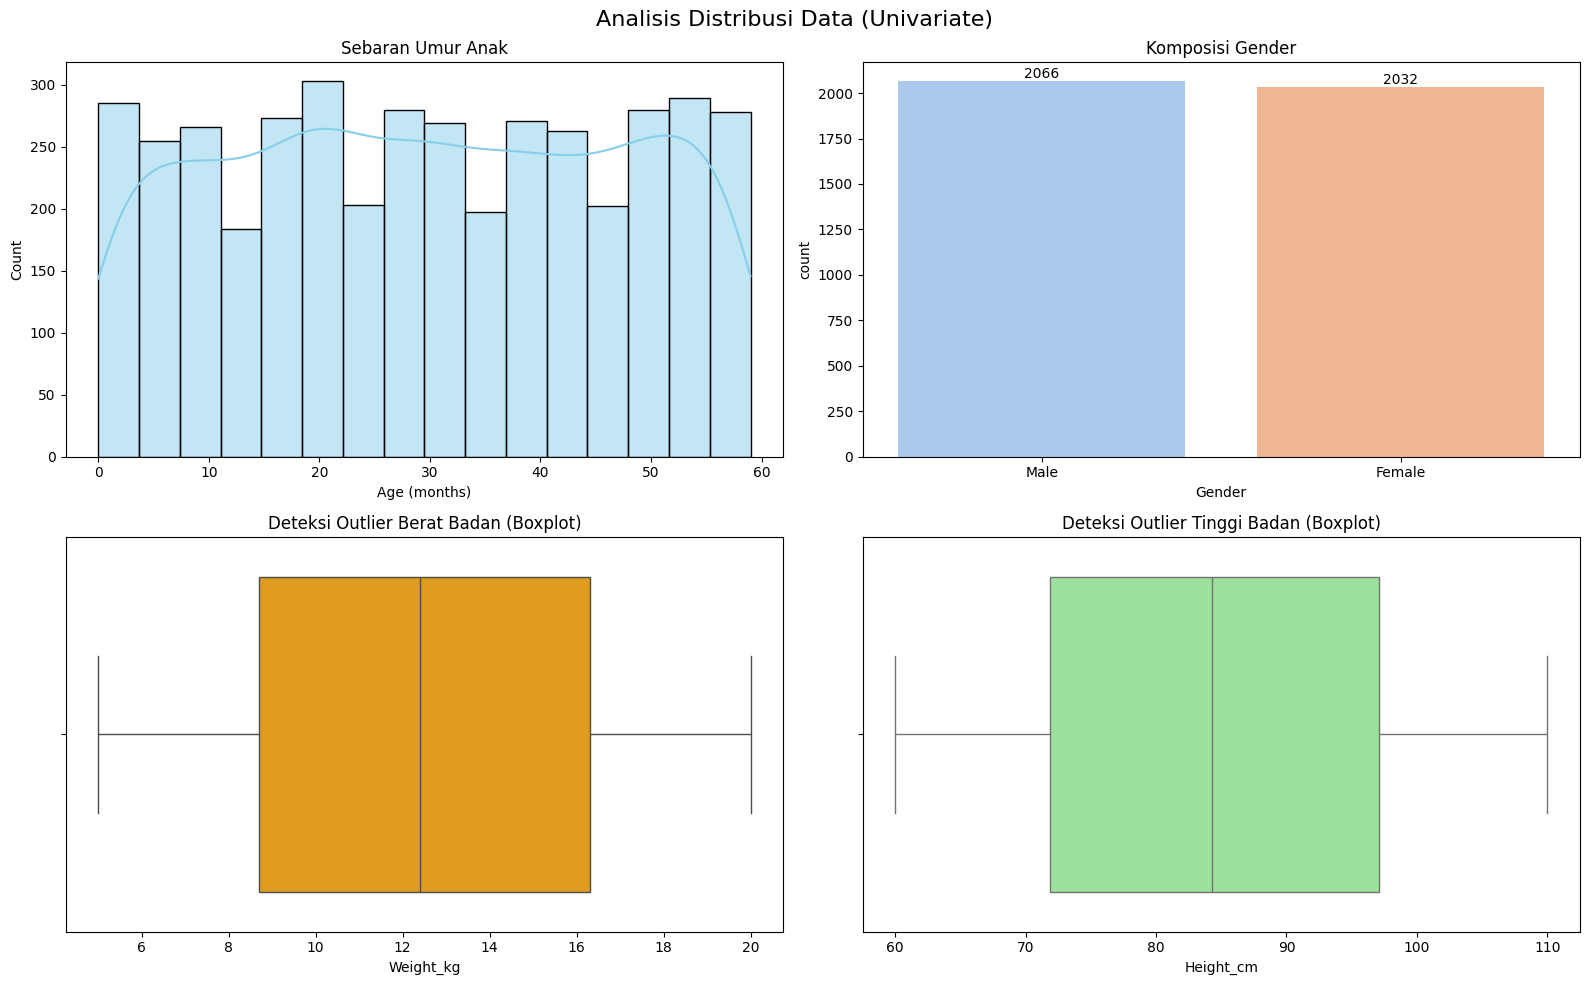

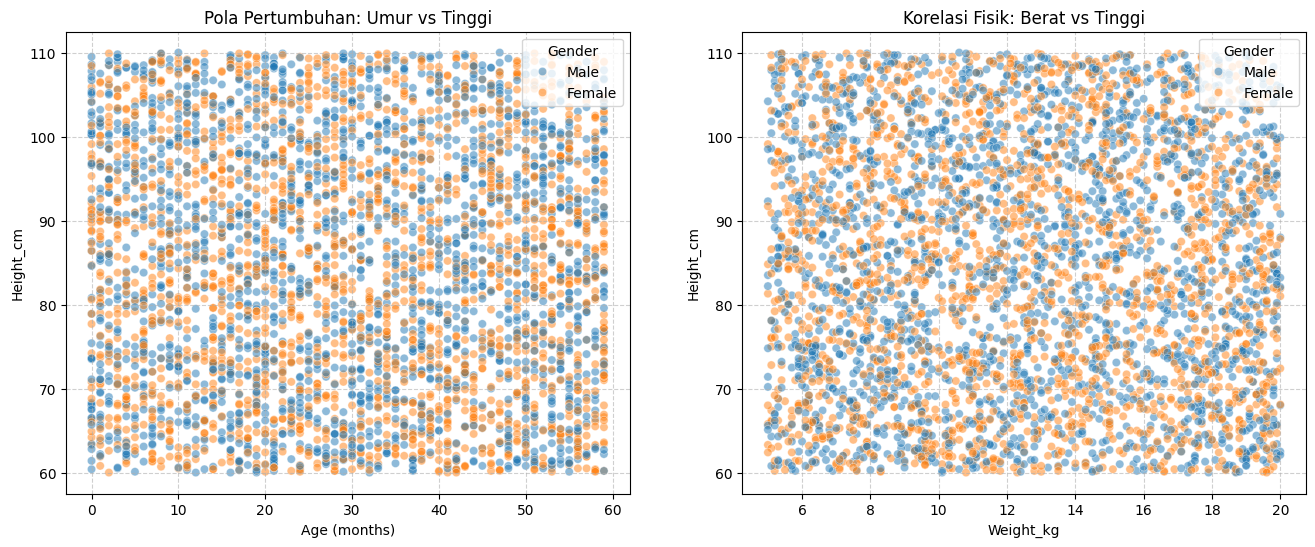

INTERPRETASI SEMENTARA:
1. Boxplot membantu melihat apakah ada data ekstrim (outlier) pada berat/tinggi.
2. Scatterplot Umur vs Tinggi harusnya membentuk garis diagonal naik (semakin tua semakin tinggi).
   Jika ada titik yang menyimpang jauh, itu mungkin indikasi stunting atau error data.

--- MENYIAPKAN DATA UNTUK TRAINING (Backend Process) ---
Data Siap! Total Bersih: 4098 baris.
Kolom 'MUAC_cm' berhasil dibuat untuk keperluan Training.
Lanjut ke Phase 3...


In [3]:
# ==========================================
# PHASE 2: DATA UNDERSTANDING, EDA & PREPARATION
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- MEMULAI PHASE 2 ---")

if 'df_real' not in locals():
    print("⚠️ df_real tidak ditemukan. Memuat ulang 'children_malnutrition_ethiopia.csv'...")
    try:
        df_real = pd.read_csv('children_malnutrition_ethiopia.csv', sep=',') 
    except:
        print("Error: children_malnutrition_ethiopia.csv tidak ditemukan.")

# A. PEMERIKSAAN KUALITAS DATA (Code by User)
print("1. Dimensi Data:", df_real.shape)
print("\n2. Tipe Data & Missing Values:")
print(df_real.info())
print("\n3. Cek Duplikasi Data:", df_real.duplicated().sum(), "baris")

# B. STATISTIK DESKRIPTIF
print("\n4. Statistik Ringkasan:")
try:
    display(df_real.describe())
except NameError: 
    print(df_real.describe()) # Fallback jika bukan di Jupyter

# C. VISUALISASI UNIVARIATE (Satu Variabel)
# Melihat sebaran data masing-masing kolom
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Analisis Distribusi Data (Univariate)', fontsize=16)

# 1. Distribusi Umur
sns.histplot(df_real['Age (months)'], kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title('Sebaran Umur Anak')

# 2. Distribusi Gender
sns.countplot(data=df_real, x='Gender', palette='pastel', ax=axes[0,1])
axes[0,1].set_title('Komposisi Gender')
for container in axes[0,1].containers:
    axes[0,1].bar_label(container)

# 3. Distribusi Berat
sns.boxplot(x=df_real['Weight_kg'], color='orange', ax=axes[1,0])
axes[1,0].set_title('Deteksi Outlier Berat Badan (Boxplot)')

# 4. Distribusi Tinggi
sns.boxplot(x=df_real['Height_cm'], color='lightgreen', ax=axes[1,1])
axes[1,1].set_title('Deteksi Outlier Tinggi Badan (Boxplot)')

plt.tight_layout()
plt.show()

# D. VISUALISASI BIVARIATE (Hubungan Dua Variabel)
# Melihat korelasi antar variabel
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

# 1. Hubungan Umur vs Tinggi (Pola Pertumbuhan)
sns.scatterplot(data=df_real, x='Age (months)', y='Height_cm', hue='Gender', alpha=0.5, ax=axes2[0])
axes2[0].set_title('Pola Pertumbuhan: Umur vs Tinggi')
axes2[0].grid(True, linestyle='--', alpha=0.6)

# 2. Hubungan Berat vs Tinggi (Status Gizi)
sns.scatterplot(data=df_real, x='Weight_kg', y='Height_cm', hue='Gender', alpha=0.5, ax=axes2[1])
axes2[1].set_title('Korelasi Fisik: Berat vs Tinggi')
axes2[1].grid(True, linestyle='--', alpha=0.6)

plt.show()

print("""INTERPRETASI SEMENTARA:
1. Boxplot membantu melihat apakah ada data ekstrim (outlier) pada berat/tinggi.
2. Scatterplot Umur vs Tinggi harusnya membentuk garis diagonal naik (semakin tua semakin tinggi).
   Jika ada titik yang menyimpang jauh, itu mungkin indikasi stunting atau error data.""")


# ==========================================
# E. DATA PREPARATION (WAJIB UNTUK NEXT PHASE)
# ==========================================
print("\n--- MENYIAPKAN DATA UNTUK TRAINING (Backend Process) ---")

# 1. Pilih Kolom Penting
required_cols = ['Age (months)', 'Gender', 'Height_cm', 'Weight_kg', 'Nutrition_Status']
df = df_real[required_cols].copy()

# 2. Bersihkan Data
df = df.dropna()

# 3. Buat LiLA Sintetis
np.random.seed(42)
def generate_synthetic_lila(row):
    status = row['Nutrition_Status']
    age = row['Age (months)']
    noise = np.random.uniform(-0.3, 0.3)
    
    if status == 'Malnourished': return np.random.uniform(9.0, 11.4) + noise
    elif status == 'At_Risk': return np.random.uniform(11.5, 12.4) + noise
    else: 
        base = 13.0 + (age * 0.04)
        return max(12.5, min(np.random.normal(base, 0.8), 20.0))

df['MUAC_cm'] = df.apply(generate_synthetic_lila, axis=1).round(1)

print(f"Data Siap! Total Bersih: {len(df)} baris.")
print("Kolom 'MUAC_cm' berhasil dibuat untuk keperluan Training.")
print("Lanjut ke Phase 3...")

In [4]:
# ==========================================
# PHASE 3: DATA PREPARATION (IMPUTASI & VALIDASI LILA)
# ==========================================
import numpy as np

print("--- MEMULAI PHASE 3 (IMPUTASI & VALIDASI) ---")

# BAGIAN A: FUNGSI GENERATOR (IMPUTASI)
print("1. Membangun Logika Imputasi...")

def impute_lila_based_on_status(row):
    status = row['Nutrition_Status']
    age = row['Age (months)']
    
    # Noise: Variasi acak +/- 0.3 cm agar data terlihat seperti pengukuran manusia asli
    noise = np.random.uniform(-0.3, 0.3)
    
    if status == 'Malnourished':
        # Kasus Gizi Buruk (Wasting)
        # Range Logis: 9.0 cm s.d 11.4 cm
        base = np.random.uniform(9.0, 11.4)
        return base + noise
    
    elif status == 'At_Risk':
        # Kasus Berisiko
        # Range Logis: 11.5 cm s.d 12.4 cm
        base = np.random.uniform(11.5, 12.4)
        return base + noise
    
    else: 
        # Kasus Normal
        # Range Logis: > 12.5 cm.
        # Kita tambahkan faktor pertumbuhan: makin tua, lengan makin besar.
        growth_factor = (age * 0.04) 
        base = 13.0 + growth_factor
        
        # Generate dengan distribusi normal (rata-rata di base)
        val = np.random.normal(base, 0.8)
        
        # Penjaga (Guard): Minimal 12.5 cm karena dia Normal
        return max(12.5, min(val, 20.0))

# BAGIAN B: EKSEKUSI (PENERAPAN KE DATA)
print("2. Menerapkan Imputasi ke seluruh data...")
df['MUAC_cm'] = df.apply(impute_lila_based_on_status, axis=1).round(1)
print(f"Sukses! {len(df)} data LiLA telah dibuat.")


# BAGIAN C: DEBUGGING & VALIDASI (PENTING!)
print("\n--- KODE DEBUGGING (VALIDASI DATA) ---")

# 1. Cek Apakah Ada Nilai Aneh? (Minus atau Nol)
cek_error = df[df['MUAC_cm'] <= 0]
if len(cek_error) > 0:
    print(f"BAHAYA: Ditemukan {len(cek_error)} data LiLA tidak valid (<= 0)!")
else:
    print("Validasi 1: Tidak ada data LiLA yang minus/nol.")

# 2. Cek Konsistensi Logika (Apakah Anak Sakit LiLA-nya beneran kecil?)
print("\nValidasi 2: Pengecekan Rata-rata LiLA per Status:")
stats = df.groupby('Nutrition_Status')['MUAC_cm'].agg(['mean', 'min', 'max', 'count'])
print(stats)

# 3. Cross-Check dengan Standar WHO (Menggunakan 'references' dari Phase 1)
print("\nValidasi 3: Cross-Check Sampel Acak vs Standar WHO")
print("(Memastikan data buatan kita sesuai kaidah medis)")

try:
    sample = df.sample(1).iloc[0] # Ambil 1 anak acak
    umur_sample = sample['Age (months)']
    gender_str = sample['Gender'] # Male/Female
    lila_sample = sample['MUAC_cm']
    
    # Ambil tabel WHO yang sesuai (jika references berhasil di-load di Phase 1)
    if 'references' in locals() and references is not None:
        tabel_who = references[gender_str]['ACFA']
        # Cari standar untuk umur ini
        row_who = tabel_who[tabel_who['Month'] == umur_sample]
        
        if not row_who.empty:
            sd_minus_2 = row_who['-2 SD'].values[0]
            print(f"\n--- Sampel Anak: {gender_str}, {umur_sample} bulan ---")
            print(f"   - LiLA Buatan Kita : {lila_sample} cm")
            print(f"   - Batas Gizi Buruk WHO (-2 SD): {sd_minus_2} cm")
            
            if lila_sample < sd_minus_2:
                print("   -> Diagnosa: Anak ini masuk kategori KURUS/MALNUTRISI.")
            else:
                print("   -> Diagnosa: Anak ini masuk kategori NORMAL/AMAN.")
            print("   (Jika status di data asli cocok dengan diagnosa ini, berarti Logika OK)")
        else:
            print("   (Data umur tidak ditemukan di tabel WHO)")
    else:
        print("   (Referensi WHO tidak tersedia, skip validasi mendalam)")

except Exception as e:
    print(f"   Skip Validasi Sample: {e}")

print("\n--- PHASE 3 SELESAI ---")

--- MEMULAI PHASE 3 (IMPUTASI & VALIDASI) ---
1. Membangun Logika Imputasi...
2. Menerapkan Imputasi ke seluruh data...
Sukses! 4098 data LiLA telah dibuat.

--- KODE DEBUGGING (VALIDASI DATA) ---
Validasi 1: Tidak ada data LiLA yang minus/nol.

Validasi 2: Pengecekan Rata-rata LiLA per Status:
                       mean   min   max  count
Nutrition_Status                              
At_Risk           11.953231  11.2  12.7   1238
Malnourished      10.159759   8.7  11.6    830
Normal            14.213744  12.5  17.8   2030

Validasi 3: Cross-Check Sampel Acak vs Standar WHO
(Memastikan data buatan kita sesuai kaidah medis)
   Skip Validasi Sample: '-2 SD'

--- PHASE 3 SELESAI ---


In [5]:
# ==========================================
# PHASE 4: PREPROCESSING & MODELING
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("--- MEMULAI PHASE 4 (MODELING) ---")

# 1. ENCODING VARIABEL KATEGORIKAL
print("1. Melakukan Encoding (Mengubah Huruf jadi Angka)...")

# A. Gender: Male=1, Female=0 (Sesuai input di App.py)
df['Gender_Code'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# B. Target: Normal=0, Berisiko/Sakit=1
# Kita sederhanakan masalah jadi Binary Classification: Aman vs Bahaya
target_map = {
    'Normal': 0,
    'At_Risk': 1,
    'Malnourished': 1
}
df['Target'] = df['Nutrition_Status'].map(target_map)

# Cek distribusi data (Seimbang gak?)
print("   Distribusi Target (0=Sehat, 1=Berisiko/Sakit):")
print(df['Target'].value_counts())


# 2. SPLITTING DATA (PEMBAGIAN)
print("\n2. Membagi Data Latih & Uji...")

# Fitur (X): Kolom yang dipakai untuk menebak
# WAJIB SAMA urutannya dengan yang ada di app.py nanti!
feature_cols = ['Age (months)', 'Weight_kg', 'Height_cm', 'MUAC_cm', 'Gender_Code']
X = df[feature_cols]

# Target (y): Kunci jawaban
y = df['Target']

# Bagi 80% untuk Latihan, 20% untuk Ujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"   - Total Data  : {len(df)} baris")
print(f"   - Data Latih  : {len(X_train)} baris (80%)")
print(f"   - Data Uji    : {len(X_test)} baris (20%)")


# 3. TRAINING MODEL (RANDOM FOREST)
print("\n3. Melatih Model Random Forest...")

# Inisialisasi Model
# n_estimators=100 -> Pakai 100 'juri' (pohon) agar keputusan lebih demokratis/akurat
# max_depth=10     -> Batasi kedalaman pohon biar gak 'menghafal' (Overfitting)
rf_model_lila = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Proses Training (Fitting)
rf_model_lila.fit(X_train, y_train)

print("   MODEL SUKSES DILATIH!")
print("   Model sekarang sudah mempelajari pola dari data 'children_malnutrition_ethiopia.csv' + LiLA Sintetis.")
print("   Siap lanjut ke Phase 5 (Evaluasi).")

--- MEMULAI PHASE 4 (MODELING) ---
1. Melakukan Encoding (Mengubah Huruf jadi Angka)...
   Distribusi Target (0=Sehat, 1=Berisiko/Sakit):
Target
1    2068
0    2030
Name: count, dtype: int64

2. Membagi Data Latih & Uji...
   - Total Data  : 4098 baris
   - Data Latih  : 3278 baris (80%)
   - Data Uji    : 820 baris (20%)

3. Melatih Model Random Forest...
   MODEL SUKSES DILATIH!
   Model sekarang sudah mempelajari pola dari data 'children_malnutrition_ethiopia.csv' + LiLA Sintetis.
   Siap lanjut ke Phase 5 (Evaluasi).


--- MEMULAI PHASE 5 (EVALUASI & EXPORT) ---
1. Menguji Model dengan Data Test...
   🎯 Akurasi Model: 98.66% (Harus di atas 85% agar layak pakai)

   📄 Laporan Detail Klasifikasi:
                    precision    recall  f1-score   support

        Normal (0)       0.98      1.00      0.99       408
Berisiko/Sakit (1)       1.00      0.98      0.99       412

          accuracy                           0.99       820
         macro avg       0.99      0.99      0.99       820
      weighted avg       0.99      0.99      0.99       820

   📊 Visualisasi Confusion Matrix:


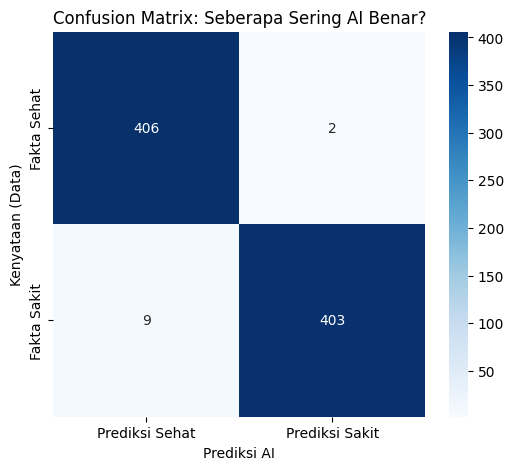


2. Menyimpan Model untuk Aplikasi...
    SUKSES! Model disimpan sebagai 'smart_growth_system.pkl'
    Lokasi: Di folder yang sama dengan notebook ini.
    Langkah Selanjutnya: Jalankan 'streamlit run app.py' untuk melihat hasilnya!

--- SELESAI. PROJECT SIAP DIPRESENTASIKAN ---


In [ ]:
# ==========================================
# PHASE 5: EVALUATION & EXPORT
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

print("--- MEMULAI PHASE 5 (EVALUASI & EXPORT) ---")

# A. EVALUASI MODEL
print("1. Menguji Model dengan Data Test...")
y_pred = rf_model_lila.predict(X_test)

# 1. Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"   🎯 Akurasi Model: {acc:.2%} (Harus di atas 85% agar layak pakai)")

# 2. Classification Report (Detail)
print("\n   📄 Laporan Detail Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Berisiko/Sakit (1)']))

# 3. Confusion Matrix (Visualisasi Salah/Benar)
print("   📊 Visualisasi Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prediksi Sehat', 'Prediksi Sakit'],
            yticklabels=['Fakta Sehat', 'Fakta Sakit'])
plt.xlabel('Prediksi AI')
plt.ylabel('Kenyataan (Data)')
plt.title('Confusion Matrix: Seberapa Sering AI Benar?')
plt.show()

# B. EXPORT MODEL (SIMPAN KE FILE)
print("\n2. Menyimpan Model untuk Aplikasi...")

# Nama file WAJIB SAMA dengan yang dipanggil di app.py
filename = 'rf_malnutrition_model.pkl'

try:
    with open(filename, 'wb') as file:
        pickle.dump(rf_model_lila, file)
    print(f"    SUKSES! Model disimpan sebagai '{filename}'")
    print("    Lokasi: Di folder yang sama dengan notebook ini.")
    print("    Langkah Selanjutnya: Jalankan 'streamlit run app.py' untuk melihat hasilnya!")
except Exception as e:
    print(f"    Gagal menyimpan model: {e}")

print("\n--- SELESAI. PROJECT SIAP DIPRESENTASIKAN ---")

In [7]:
# ==========================================
# SIMPAN DATASET BARU KE CSV
# ==========================================
print("\n--- MENYIMPAN DATASET BARU (DENGAN LiLA) ---")

# Nama file output
output_csv = 'dataset_lengkap_lila.csv'

# Simpan df (yang sudah ada LiLA-nya) ke CSV
# index=False artinya nomor baris (0,1,2..) gak usah ikut disimpan
df.to_csv(output_csv, index=False)

print(f"  SUKSES! Dataset baru berhasil disimpan sebagai '{output_csv}'")
print("   Sekarang file ini punya kolom: Umur, Berat, Tinggi, Gender, Status, DAN LiLA.")


--- MENYIMPAN DATASET BARU (DENGAN LiLA) ---
  SUKSES! Dataset baru berhasil disimpan sebagai 'dataset_lengkap_lila.csv'
   Sekarang file ini punya kolom: Umur, Berat, Tinggi, Gender, Status, DAN LiLA.
